<a href="https://colab.research.google.com/github/rory619/Final-Year-Project/blob/main/FruitRipenessV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Setup and Imports

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


2. Mount Google Drive and Locate Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)



CANDIDATES = [
    "/content/drive/MyDrive/Colab Notebooks/fruit ripeness/train",
    "/content/drive/My Drive/Colab Notebooks/fruit ripeness/train",
]

DATA_DIR = next((p for p in CANDIDATES if os.path.isdir(p)), None)
if DATA_DIR is None:
    raise RuntimeError(
        "Train folder not available. Checked:\n" + "\n".join(CANDIDATES)
    )

print("Using dataset folder:", DATA_DIR)
print("Class folders:", os.listdir(DATA_DIR))

Mounted at /content/drive
Using dataset folder: /content/drive/MyDrive/Colab Notebooks/fruit ripeness/train
Class folders: ['UnripeBanana', 'UnripeOrange', 'RottenOrange', 'RottenBanana', 'RipeOrange', 'RipeBanana']


3. Create Training and Validation Datasets and performance helpers

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)

print("Classes:", class_names)
print("Number of classes:", NUM_CLASSES)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)

Found 3074 files belonging to 6 classes.
Using 2460 files for training.
Found 3074 files belonging to 6 classes.
Using 614 files for validation.
Classes: ['RipeBanana', 'RipeOrange', 'RottenBanana', 'RottenOrange', 'UnripeBanana', 'UnripeOrange']
Number of classes: 6


4. Visualise a sample

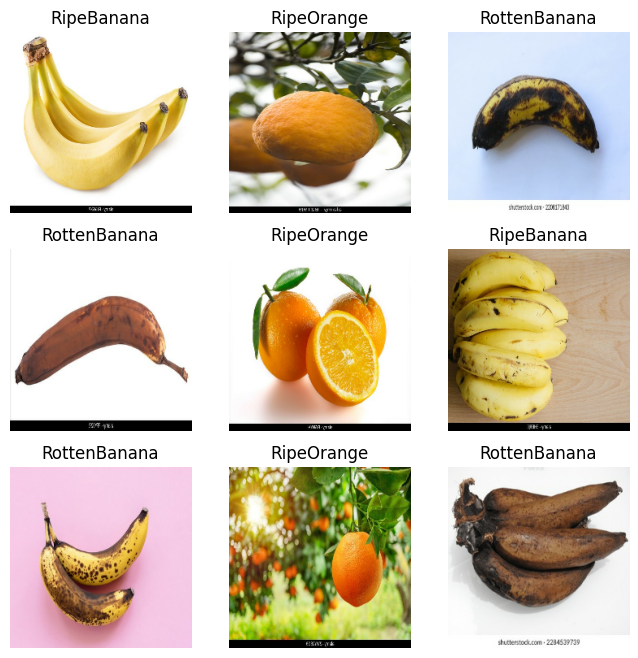

In [ ]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

5. Build the Transfer Learning Model (MobileNetV2)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
    ],
    name="data_augmentation",
)

# using a pre trained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False  # freeze to execute faster

# Building the model
inputs = keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)


x = layers.Rescaling(1./127.5, offset=-1.0)(x)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Model diagram

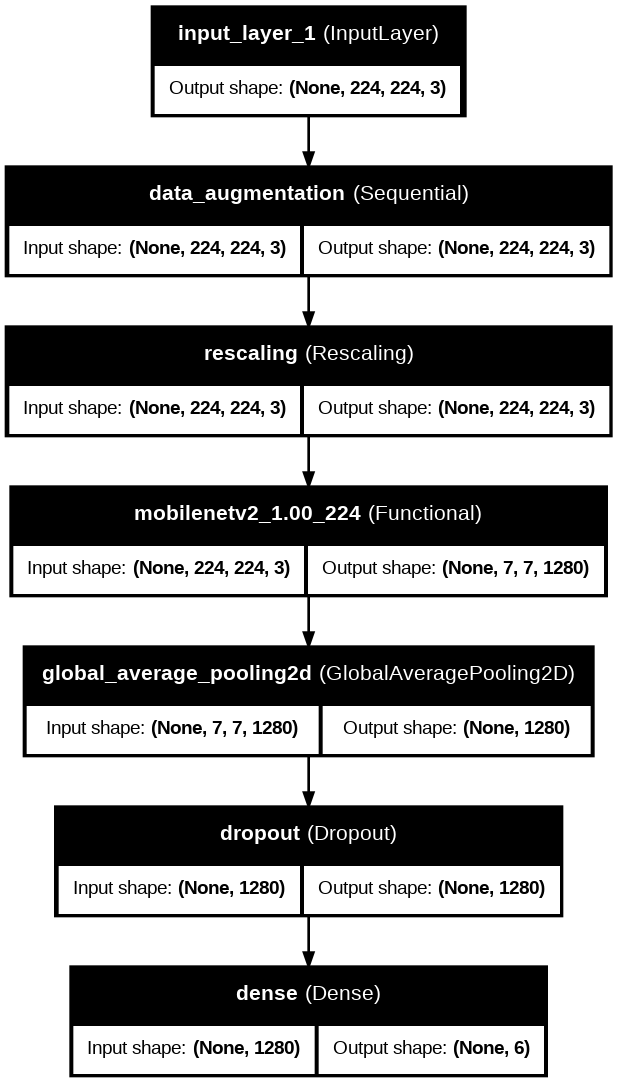

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(
    model,
    to_file="fruit_model.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=96,
)

6. Train the model

In [ ]:
EPOCHS = 6

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)

Epoch 1/6
77/77 ━━━━━━━━━━━━━━━━━━━━ 334s 4s/step - accuracy: 0.6923 - loss: 0.8803 - val_accuracy: 0.9560 - val_loss: 0.1514
Epoch 2/6
77/77 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.9575 - loss: 0.1579 - val_accuracy: 0.9642 - val_loss: 0.1038
Epoch 3/6
77/77 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.9794 - loss: 0.0983 - val_accuracy: 0.9723 - val_loss: 0.0827
Epoch 4/6
77/77 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.9748 - loss: 0.0857 - val_accuracy: 0.9821 - val_loss: 0.0690
Epoch 5/6
77/77 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.9865 - loss: 0.0657 - val_accuracy: 0.9788 - val_loss: 0.0618
Epoch 6/6
77/77 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.9876 - loss: 0.0554 - val_accuracy: 0.9821 - val_loss: 0.0593


Plot training curves

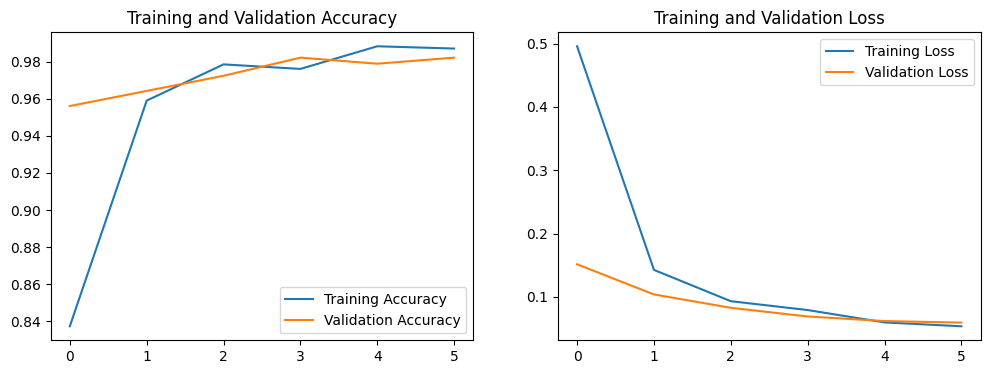

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.show()


7. Evaluate the Model on Validation Data

In [ ]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation accuracy: {val_acc:.4f}")
print(f"Validation loss: {val_loss:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9792 - loss: 0.0742
Validation accuracy: 0.9821
Validation loss: 0.0593


8. Test with One Fruit Image

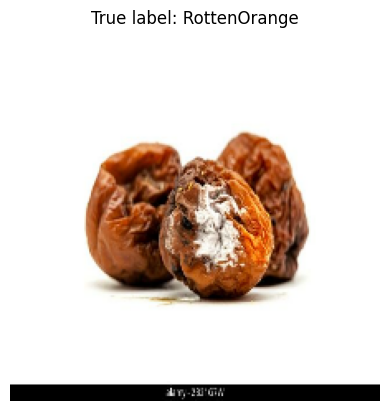

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
True label index: 3
Predicted label index: 3
Predicted class name: RottenOrange


In [ ]:
# Take an image and label from the validation set
for images_batch, labels_batch in val_ds.take(1):
    test_image = images_batch[0]   # shape (224, 224, 3)
    true_label = labels_batch[0].numpy()

    break

plt.imshow(test_image.numpy().astype("uint8"))
plt.title(f"True label: {class_names[true_label]}")
plt.axis("off")
plt.show()


# The model expects a batch dimension of (1, 224, 224, 3)
test_image_expanded = np.expand_dims(test_image, axis=0)

predictions = model.predict(test_image_expanded)
predicted_index = np.argmax(predictions[0])
predicted_label = class_names[predicted_index]

print(f"True label index: {true_label}")
print(f"Predicted label index: {predicted_index}")
print(f"Predicted class name: {predicted_label}")

9. Export for Raspberry Pi

In [ ]:
OUTPUT_DIR = "/content/fruit_ripeness_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1) Save Keras model
keras_path = os.path.join(OUTPUT_DIR, "model.keras")
model.save(keras_path)
print("Saved Keras model to:", keras_path)

# 2) Save class labels
labels_path = os.path.join(OUTPUT_DIR, "labels.txt")
with open(labels_path, "w") as f:
    for name in class_names:
        f.write(name + "\n")
print("Saved labels to:", labels_path)

# 3) Convert to TFLite and optimize it
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_path = os.path.join(OUTPUT_DIR, "model.tflite")
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

print("Saved TFLite model to:", tflite_path)

Saved Keras model to: /content/fruit_ripeness_output/model.keras
Saved labels to: /content/fruit_ripeness_output/labels.txt
Saved artifact at '/tmp/tmp1fzve1nc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  133014940280080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133014940281232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133014940280272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133014940282960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133014940282192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133014940281424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133014940284496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133014940284688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133014940282384: TensorSpe